In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

% matplotlib inline

## Question 2

### Download dataset

In [2]:
import os
import urllib.request
import zipfile

data_dir = '/data/flights'
    
data_dir = os.path.join(data_dir)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

yr = [2014, 2015, 2016]
mm = np.arange(1,13)

for y in yr:
    for m in mm:
        DATA_URL = 'https://transtats.bts.gov/PREZIP/On_Time_On_Time_Performance_{}_{}.zip'.format(y, m)

        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath)
            zip_ref = zipfile.ZipFile(filepath, 'r')
            zip_ref.extractall(data_dir)
            zip_ref.close()
            print('Successfullly downloaded', filename)

Successfullly downloaded On_Time_On_Time_Performance_2014_1.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_2.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_3.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_4.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_5.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_6.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_7.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_8.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_9.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_10.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_11.zip
Successfullly downloaded On_Time_On_Time_Performance_2014_12.zip
Successfullly downloaded On_Time_On_Time_Performance_2015_1.zip
Successfullly downloaded On_Time_On_Time_Performance_2015_2.zip
Successfullly downloaded On_Time_On_Time_Performance_2015_3.zip
Successfullly downloaded On_Time_On_T

### Change data-format to reduce memory usage

First, we will take an example table and inspect the memory usage for each data type: float, int and object

In [41]:
filename = '/data/flights/On_Time_On_Time_Performance_2014_1.csv'
data_fl = pd.read_csv(filename)

In [ ]:
for dtype in ['float64','int64','object']:
    data_dtype = data_fl.select_dtypes(include=[dtype])
    tt_usage_b = data_dtype.memory_usage(deep=True).sum()
    tt_usage_mb = tt_usage_b / 1024 ** 2
    print("Total memory usage for {} columns: {:.3f} MB".format(dtype, tt_usage_mb))

In [3]:
def memory_usage(df):
    tt_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print("Total memory usage {:.3f} MB".format(tt_usage))

Before merging all the table, we will apply down-casting without losing informaiton on int, float data type. We will also change the NAN data type as well as use category datatypte to store object variable.

In [2]:
def down_cast(df, filename):
    
    print('Downcasting...' + filename.split('/')[-1])
    df_int = df.select_dtypes(include=['int'])
    df_float = df.select_dtypes(include=['float'])
    df_obj = df.select_dtypes(include=['object'])
    
    df_int_cv = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float_cv = df_float.apply(pd.to_numeric, downcast='float')
    null_columns= df_float_cv.columns[df_float_cv.isnull().all()]
    df_float_cv[null_columns] = df_float_cv[null_columns].astype('float16')
    
    df_obj_cv = pd.DataFrame()
    for col in df_obj.columns:
        num_unique_values = len(df_obj[col].unique())
        num_total_values = len(df_obj[col])
        if num_unique_values / num_total_values < 0.5:
            df_obj_cv.loc[:,col] = df_obj[col].astype('category')
        else:
            df_obj_cv.loc[:,col] = df_obj[col]
            
    pd_new = pd.concat([df_int_cv, df_obj_cv, df_float_cv], axis=1)
    
    return pd_new

In [62]:
memory_usage(data_fl)
data_fl_cv = down_cast(data_fl)
memory_usage(data_fl_cv)

Total memory usage 800.439 MB
Downcasting...
Total memory usage 199.354 MB


### Process each .csv file and combine them

In [3]:
data_fl = pd.DataFrame(data=None)

yr = [2014, 2015, 2016]
mm = np.arange(1,13)
for y in yr:
    for m in mm:
        filename = '/data/flights/On_Time_On_Time_Performance_{}_{}.csv'.format(y, m)
        print('Processing ' + filename + '...')

        data_tmp = pd.read_csv(filename)
        data_tmp_cv = down_cast(data_tmp, filename)
        data_fl = data_fl.append(data_tmp_cv)

Processing /data/flights/On_Time_On_Time_Performance_2014_1.csv...
Downcasting...On_Time_On_Time_Performance_2014_1.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_2.csv...
Downcasting...On_Time_On_Time_Performance_2014_2.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_3.csv...
Downcasting...On_Time_On_Time_Performance_2014_3.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_4.csv...
Downcasting...On_Time_On_Time_Performance_2014_4.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_5.csv...
Downcasting...On_Time_On_Time_Performance_2014_5.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_6.csv...
Downcasting...On_Time_On_Time_Performance_2014_6.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_7.csv...
Downcasting...On_Time_On_Time_Performance_2014_7.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_8.csv...
Downcasting...On_Time_On_Time_Performance_2014_8.csv
Processing /data/flights/On_Time_On_Time

In [11]:
# Save data locally
# data_fl.to_pickle('data_flight')

In [5]:
data_fl = pd.read_pickle('data_flight')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17256548 entries, 0 to 460948
Columns: 110 entries, ActualElapsedTime to Year
dtypes: category(2), float32(44), float64(25), object(18), uint16(9), uint32(2), uint8(10)
memory usage: 9.1+ GB


In [8]:
data = pd.read_pickle('data_flight')

In [10]:
np.array(data.columns)

array(['ActualElapsedTime', 'AirTime', 'AirlineID', 'ArrDel15', 'ArrDelay',
       'ArrDelayMinutes', 'ArrTime', 'ArrTimeBlk', 'ArrivalDelayGroups',
       'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'CancellationCode',
       'Cancelled', 'Carrier', 'CarrierDelay', 'DayOfWeek', 'DayofMonth',
       'DepDel15', 'DepDelay', 'DepDelayMinutes', 'DepTime', 'DepTimeBlk',
       'DepartureDelayGroups', 'Dest', 'DestAirportID', 'DestAirportSeqID',
       'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips',
       'DestStateName', 'DestWac', 'Distance', 'DistanceGroup',
       'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID',
       'Div1LongestGTime', 'Div1TailNum', 'Div1TotalGTime',
       'Div1WheelsOff', 'Div1WheelsOn', 'Div2Airport', 'Div2AirportID',
       'Div2AirportSeqID', 'Div2LongestGTime', 'Div2TailNum',
       'Div2TotalGTime', 'Div2WheelsOff', 'Div2WheelsOn', 'Div3Airport',
       'Div3AirportID', 'Div3AirportSeqID', 'Div3LongestGTime',
       'Div3TailNum', 'Div

### Identify top 10 busiest departure and arrivel airport over time

In [11]:
# Find all the depart airport that has been on the top 10
def findBusyAirport(data, airptkey='OriginAirportID', timeperiod='YY-M', topn=10):
    
    # Create column with key information
    
    df_agg = data.groupby([timeperiod, airptkey]).agg({airptkey:'count'})
    g = df_agg[airptkey].groupby(level=0, group_keys=False)
    topn_df = g.nlargest(topn)

    dict_departID = {}

    multi_index = topn_df.index
    values = topn_df.values

    for i in range(len(multi_index)):
        mm, departID = multi_index[i]
        if departID not in dict_departID:
            dict_departID[departID] = []

    key_list = list(dict_departID.keys())
    # Fill in the occurance
    for j in range(len(topn_df.index.levels[0])):
        curr_departID = list(topn_df.index.get_level_values(1))[j * topn: j * topn + topn]
        curr_values = values[j * topn: j * topn + topn]
        for departID in key_list:
            if departID in curr_departID:
                index_departID = curr_departID.index(departID)
                dict_departID[departID].append(curr_values[index_departID])
            else:
                dict_departID[departID].append(np.nan)
    
    return list(topn_df.index.levels[0]), dict_departID

In [12]:
# We will take month as the bin for study busy level: number of departure(arraive)/month
# Creat unique identifier 'YY-M'
data['YY-M'] = data['Year'].astype(int) * 100 +  data['Month'].astype(int)

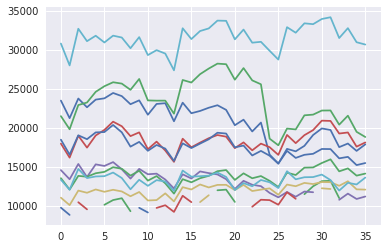

In [13]:
yy_m, top10_depart = findBusyAirport(data, 'OriginAirportID', topn=10)
for key in top10_depart.keys():
    plt.plot(top10_depart[key], '-')

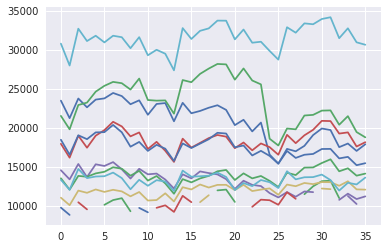

In [14]:
yy_m, top10_arr = findBusyAirport(data, 'DestAirportID', topn=10)
for key in top10_arr.keys():
    plt.plot(top10_arr[key], '-')

### Identify the top 150 busiest airport during 2016 (last 12 month)

In [18]:
_, top150_depart = findBusyAirport(data[data['Year']==2016], airptkey='OriginAirportID', timeperiod='Year', topn=150)
_, top150_ori = findBusyAirport(data[data['Year']==2016], airptkey= 'DestAirportID', timeperiod='Year', topn=150)